**1. How would you go about combining the three lexicons with different ways to quantify sentiments into a single one, conceptually? (You can implement it if you wish, but this is not required.) What would you do with words that appear in two or more lexicons?**

In [1]:
install.packages("tidytext") # only install ONCE on your own computer
install.packages("tm") # only install ONCE on your own computer
install.packages("textdata") # this is new for Session 3, install now if using your own computer

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘SnowballC’, ‘hunspell’, ‘janeaustenr’, ‘tokenizers’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘NLP’, ‘slam’, ‘BH’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [434]:
library(tidytext)
library(textdata)
library(dplyr) # needed for piping with %>%
interactive() # this is NOT an interactive R GUI so we cannot answer "Do you want to download" dialogues
tns <- getNamespace("textdata") # so, unless we run this on a local machine, we need to do more steps
assignInNamespace(x = "printer", value = function(...) 1, ns = tns) # a workaround from https://community.rstudio.com/t/is-there-a-way-to-make-the-choices-asked-for-in-the-package-always-yes/105442

[1] FALSE

In [5]:
# The AFINN lexicon assigns words with a score that runs between -5 and 5, 
# with negative scores indicating negative sentiment and positive scores indicating positive sentiment.

afinn <- get_sentiments("afinn")
colnames(afinn)[2] = "AFINN"
head(afinn)

word,AFINN
<chr>,<dbl>
abandon,-2
abandoned,-2
abandons,-2
abducted,-2
abduction,-2
abductions,-2


In [6]:
# The NRC lexicon categorizes words in a binary fashion (“yes”/“no”) into categories of sentiement: positive, negative, 
# and emotion: anger, anticipation, disgust, fear, joy, sadness, surprise, and trust. 
nrc <- get_sentiments("nrc")
colnames(nrc)[2] = "NRC"
head(nrc)

word,NRC
<chr>,<chr>
abacus,trust
abandon,fear
abandon,negative
abandon,sadness
abandoned,anger
abandoned,fear


In [7]:
# The Bing lexicon categorizes words in a binary fashion into positive and negative categories.
bing <- get_sentiments("bing")
colnames(bing)[2] = "Bing"
head(bing)

word,Bing
<chr>,<chr>
2-faces,negative
abnormal,negative
abolish,negative
abominable,negative
abominably,negative
abominate,negative


In [8]:
l1 <- afinn %>% 
    mutate(sentiment = case_when(AFINN > 0 ~ "positive", AFINN < 0 ~ "negative"))
head(l1)

word,AFINN,sentiment
<chr>,<dbl>,<chr>
abandon,-2,negative
abandoned,-2,negative
abandons,-2,negative
abducted,-2,negative
abduction,-2,negative
abductions,-2,negative


In [9]:
l2 <- merge(x = nrc, y = l1, by = "word", all = TRUE) %>% filter(NRC %in% c('positive', 'negative')) %>% 
    mutate(sentiment = case_when(NRC ==  "positive" ~ "positive", NRC == "negative" ~ "negative", is.na(NRC) ~ sentiment))
head(l2)

,word,NRC,AFINN,sentiment
,<chr>,<chr>,<dbl>,<chr>
1,abandon,negative,-2,negative
2,abandoned,negative,-2,negative
3,abandonment,negative,NA,negative
4,abba,positive,NA,positive
5,abduction,negative,-2,negative
6,aberrant,negative,NA,negative


In [10]:
l3 <- merge(x = bing, y = l2, by = "word", all = TRUE) %>% 
    mutate(sentiment = case_when(Bing ==  "positive" ~ "positive", Bing == "negative" ~ "negative", is.na(Bing) ~ sentiment))
l3 %>% filter(word == 'wrong')

word,Bing,NRC,AFINN,sentiment
<chr>,<chr>,<chr>,<dbl>,<chr>
wrong,negative,negative,-2,negative


In [11]:
v <- l3 %>% group_by(sentiment) %>% count(sentiment)
v 
nrow(l3)

sentiment,n
<chr>,<int>
negative,6416
positive,3621


[1] 10037

Le lexique AFINN est défini par des mots positifs (> 0) et des mots négatifs (< 0). Nous pouvons transformer ces résultats numériques en caractère positif / négatif. Le lexique NRC se compose de sentiment (positif/négatif) et d'émotion (anger, anticipation, disgust, fear, joy, sadness, surprise, trust). Nous pouvons prendre que les sentiments (positif/négatif). Le lexique Bing se compose seulement de mots positifs et négatifs. Les 3 lexiques sont donc ramenés aux sentiments négatifs et positifs et compose un lexique plus vaste de sentiment lorsqu’ils sont agrégés ensemble. Les trois lexiques sont différents pour calculer le sentiment et donnent des résultats qui sont différents dans l'absolu mais qui ont des trajectoires relatives similaires à travers un document. (ex : Afinn – faire la somme des nombres par segmentation vs. Bing – faire la somme des mots positif/négatif).

Pour ce qui est des émotions dans le lexique NRC, pour un mot donné, il peut se retrouver dans plusieurs émotions (ex : abandonment – surprise / sadness / fear / anger). Il est donc logique de se trouver avec des doublons pour ces cas et l’analyse de sentiment se doit de les prendre en considération en raison que l’abandon peut générer de la peur et de la tristesse à titre d’exemple. 

**2. Pick a text repository of your choice (you can use the three set of reviews of the example code to take the short way out or pick some other open data or process something from your work).
What percentage of the words (after cleaning out stop words) of the repository are present in each of the three sentiment lexicons?**

In [435]:
library(tidyverse)
library(rvest)

In [447]:
# we base this on a vignette from https://martinctc.github.io/blog/vignette-scraping-amazon-reviews-in-r/ 
webscrape <- function(ASIN){
  url <- paste0("https://www.amazon.ca/product-reviews/", ASIN, "/?pageNumber=1") # just the first page
  doc <- read_html(url)
  doc %>% 
    html_nodes("[class='a-size-base review-text review-text-content']") %>% html_text() -> content
  doc %>%
    html_nodes("[data-hook='review-star-rating']") %>% html_text() -> review_star
  return(tibble(content, review_star))
}

In [448]:
#first <- mutate(webscrape("1492054054"), title = "Practical NLP") # https://www.amazon.com/Practical-Natural-Language-Processing-Pragmatic/dp/1492054054/
#second <- mutate(webscrape("1491978236"), title = "NLP with PyTorch") # https://www.amazon.ca/Natural-Language-Processing-PyTorch-Applications/dp/1491978236/
#third <- mutate(webscrape("1617294632"), title = "NLP in Action") # https://www.amazon.ca/Natural-Language-Processing-Action-Understanding/dp/1617294632/

first <- mutate(webscrape("0593534328"), title = "Italian") # https://www.amazon.com/Essentials-Classic-Italian-Cooking-Anniversary/dp/0593534328/
second <- mutate(webscrape("1579658768"), title = "France") # https://www.amazon.com/Lets-Eat-France-specialty-personalities/dp/1579658768/
third <- mutate(webscrape("194464895X"), title = "China") # https://www.amazon.com/China-Study-Cookbook-Expanded-Plant-Based/dp/194464895X/

first
second
third

content,review_star,title
<chr>,<chr>,<chr>
"The recipes are very well explained and although I have only done a few to date they were excellent. I agree with someone else's comments on the basic red sauce - best ever and only 3 ingredients - so simple and prefect. I made it for two young grandchildren and they both said it was the best sauce ever. For those who complain about no pictures I say it's a cookbook, not a photo album. Ridiculous reason to give a cookbook a bad rating. I am buying another copy for my daughter-in-law.",5.0 out of 5 stars,Italian
"Even with the internet and the rise of cooking blogs and recipe sites, there are certain cookbooks I think one should own, preferably in hard cover. Marcella Hazan’s Classic Italian is one of those books.In my humble opinion of course.",5.0 out of 5 stars,Italian
I was hoping for more from this book. The few recipes I made were uneventful. The simple onion/butter tomato sauce was extremely bland and boring. If you don't know how to cook at all then this book will help you develop some basics. It doesn't do a good job at teaching you how to develop flavors so that you'll actually want to eat the meal.,3.0 out of 5 stars,Italian
"So far it's wonderful. Not only do you get an incredibly vast library of wonderfully authentic recipes, but also some history as well as instructions on technique and kitchen hardware essentials. She also covers what every good Italian pantry should have on hand. If you want Italian cuisine this is the only book you'll ever need.",5.0 out of 5 stars,Italian
"This is an amazing book for those who are not shy about cooking from scratch. The recipes are positively brilliant and easy to follow. That said, it is not for the faint of heart...there is a lot of prep for fresh vegetables, fresh meats and all other manner of fresh ingredients. But the effort is more than worth the time and energy required. My husband & I entered a ""food coma"" after stuffing ourselves with the pizza recipes in this book...it was the first recipe I tried after my sister recommended the book to me...her family may never ever again go to a restaurant for dinner now that my sister has discovered this book. I cannot say enough wonderful things about the recipes found in this cook book. Bravo and bon appetite !",5.0 out of 5 stars,Italian
"Ma conjointe est tombée en amour avec ce livre. Très bonne achat, très bien expliqué le livre est en anglais mais avec une bonne base il y est facile de comprendre. Fortement recommandé",5.0 out of 5 stars,Italian
"The book itself is excellent, an incredible resource. However it was delivered with the corners pretty badly damaged. Seems standard for Amazon to deliver books this way, not wrapping them properly and seriously damaging them. Disappointing.Honestly I would recommend finding a local bookstore that has this in stock instead.",2.0 out of 5 stars,Italian
"I haven't made any recipes yet but this book doesn't disappoint. I love that like the joy of cooking, there is a lot of instruction for how to prep and prepare the foods, not just a recipe. I'm 126 pages in and have already learned quite a bit .",4.0 out of 5 stars,Italian
"The best of the best Italian cookbook I've ever owned. It's the kind of the book that the recipes are really authentic and the outcome is really delicious, which, according to my experience, is extremely rare nowadays. I've had it for more than 4 years and have tried many recipes on it. As far as I can remember, only two recipes disappoints me (and I'm a really difficult person when it comes to food). I also bought many other Italian cookbooks, with many mouth-watering pictures but most of the time, the outcome following those books are mediocre and do not worth the effort.",5.0 out of 5 stars,Italian


content,review_star,title
<chr>,<chr>,<chr>
"I saw this book at Indigo, wanted it badly, and decided to Amazon it first, saving about 30% in the process. It is full of a wide range of culinary information, starting with a history of the topic, and progressing to the finer points of French cuisine. The information is top-notch, the illustrations are entertaining, the layout and content are exceptional, quality is great, and I am thoroughly impressed with the book after being interested in the culinary arts since the age of 11 (now 31). This is certainly not of the anyone-can-write-a-recipe-book-but-that-doesn't-mean-it's-good variety.",5.0 out of 5 stars,France
"Tons of history, fun facts and 100's of wonderful, tasty recipes thrown in. It reads like a crash history on who's who of French cooking. Glad we added it to our French cooking collection. Well balanced recipes of main meals, breakfast, lunch and appetizers.",5.0 out of 5 stars,France
After what seemed to be some confusing e mails and possibly some misunderstandings I finally received my book. A little late but in good condition. It’s a great book I’m glad to have it.,4.0 out of 5 stars,France
It is a big ass book! lol. Probably weighs 3-5lbs and is 9.9 x 1.7 x 13.1 inches. I love that it's hard cover. It's really beautiful book and I love all of the colours on the front cover. It was a bit delayed in arriving but it came in perfect condition. I can't comment on the substance of the book or how the recipes turned out since this is a Christmas gift but if I get any feedback I'll update the review.,5.0 out of 5 stars,France
Lover all the fine details and stories.,5.0 out of 5 stars,France
"loved it ,its mixture of history ,fgacts and recipes",5.0 out of 5 stars,France
Broad coverage of french cuisine with lots of background and interesting tidbits of history as well. Thank you to Chef Ricardo for recommending it!,5.0 out of 5 stars,France
"Beautiful book, well made but most importantly very interesting for people that love to cook.",5.0 out of 5 stars,France
"Ouvrage complet, couvre la cuisine française de A à Z. Cadeau pour le chum cuisinier, il a adoré :)",5.0 out of 5 stars,France


content,review_star,title
<chr>,<chr>,<chr>
"I barely ever use cookbooks after buying them, but this one I actually did get around to using it frequently. For two reasons 1) I wanted to learn some vegan recipies and most importantly 2) these recipes are very easy to make, with a small number of ingredients. I didn't need to spend $300 on different weird spices and things from the grocery store. I had almost everything already, with the odd exception (when there was an exception I could use it on multiple recipies). I have actually now cooked almost everything in this book and have heard the words ""I had no idea this was vegan, this is the best vegan food I have ever eaten"" so many times now that I have learnt a lot of the recipes off by heart. Can't recommend it enough. I have converted many a meat eater to a few of these recipies as staples in their own houses too :)",5.0 out of 5 stars,China
"We have made several recipes from the book so far and have enjoyed them a great deal! Our favourites are the recipe for fettuccini with broccoli and white sauce, the squash Mac and cheese recipe and the sauces!! The recipes are creative and healthy and don’t include oil. I highly recommend this book to my friends and family!!The recipes are easy and do not contain difficult to find ingredients!",5.0 out of 5 stars,China
"This book has some really nice recipes, and I particularly like some of the soups and sauces -- have combinations of ingredients I could not have thought of on my own. Being a plant-based diet, the only issue I have with it is that many of the recipes have more carbohydrate content than I would like (being more of a paleo-type diet person), but one can work around those. Otherwise, some really neat ideas here.In the photos are some of the recipes I made:- Asian Noodle Salad;- Dominican Chapea; and- Ensalada Azteca (without the rice).",4.0 out of 5 stars,China
"I am pleased with most recipes I have tried so far (5) but I have to say one of them has probably not been tested because it just doesn’t work and the image is very misleading.Page 288 Chocolate Brownie Birthday Cake. I was very excited to try it, bought all the ingredients, diced and cooked a sweet potato, bought Medjool dates... But take 1/4 cup of cooked diced sweet potatoes, 1/4 cup of Medjool dates et 3 tablespoons of cocoa, and you’ll end up with a very thick and hard paste, not a smooth icing. And that is if you can blend it. I have tried a food processor and also a Vitamix. Not near the quality and quantity shown on the image. The picture shows a light and creamy frosting and a lot more frosting than you really get. I am just frustrated because of all the effort, the preparation, the shopping for ingredients, the waste of food and cleaning the mess for nothing. Plus I tasted the so called “icing” and it’s very bitter. I threw everything away.So I have mixed feelings about the cookbook. I hope I won’t get disappointed again.",3.0 out of 5 stars,China
"This is the one and only cook book I would suggest. Natural, smart food that will help you lose weight and get more minerals and vitamins into your body. Full of good healthy recipes and information that will help you eat better.",5.0 out of 5 stars,China
"Great book, i love that there are pictures for every recipe.",5.0 out of 5 stars,China
"The pictures are gorgeous, even the little stuff like the different mayos, soya sauces and dips all have photos. The recipes this far are fantastic and I’m finding myself using this cookbook more than the other ones I have. 5 stars!",5.0 out of 5 stars,China
Good recipes. Only good thing would be a nutritional guide of how much calories and such.,4.0 out of 5 stars,China
This is an exceptional book for those following a plant based diet. Recipes that I tried are good and different. Pictures are very inviting. The index was confusing and I found it difficult to find recipes or information.,4.0 out of 5 stars,China


In [465]:
# combine the 3 reviews of book 
combo <- rbind(first, second, third)
combo1 <- combo %>% count(title)
combo1

title,n
<chr>,<int>
China,10
France,10
Italian,10


In [466]:
# token by word for each review
reviews <- combo %>% mutate(review = row_number()) 
data <- reviews %>% unnest_tokens(word, content, to_lower = TRUE)
head(data)

review_star,title,review,word
<chr>,<chr>,<int>,<chr>
5.0 out of 5 stars,Italian,1,the
5.0 out of 5 stars,Italian,1,recipes
5.0 out of 5 stars,Italian,1,are
5.0 out of 5 stars,Italian,1,very
5.0 out of 5 stars,Italian,1,well
5.0 out of 5 stars,Italian,1,explained


In [467]:
# clean with the stopword
clean <- data %>% filter(!word %in% stop_words$word)
head(clean)

review_star,title,review,word
<chr>,<chr>,<int>,<chr>
5.0 out of 5 stars,Italian,1,recipes
5.0 out of 5 stars,Italian,1,explained
5.0 out of 5 stars,Italian,1,date
5.0 out of 5 stars,Italian,1,excellent
5.0 out of 5 stars,Italian,1,agree
5.0 out of 5 stars,Italian,1,else's


In [468]:
# count the total of word for each book
t <- clean %>% group_by(title) %>% count(title) 
colnames(t)[2] = "Total"
head(t)

title,Total
<chr>,<int>
China,245
France,158
Italian,251


In [469]:
# count the word in the afinn lexicon for each book
c_afinn <- clean %>% inner_join(afinn) %>% group_by(title) %>% count(title) 
colnames(c_afinn)[2] = "n_afinn"
#head(c_afinn)

Joining, by = "word"


In [454]:
# count the word in the nrc lexicon for each book
c_nrc <- clean %>% inner_join(nrc) %>% filter(NRC %in% c('positive', 'negative')) %>% group_by(title) %>% count(title) 
colnames(c_nrc)[2] = "n_nrc"
#head(c_nrc)

Joining, by = "word"


In [455]:
# count the word in the bing lexicon for each book
c_bing <- clean %>% inner_join(bing) %>% group_by(title) %>% count(title) 
colnames(c_bing)[2] = "n_bing"
#head(c_bing)

Joining, by = "word"


In [456]:
total <- merge(x = c_afinn, y = c_nrc, by = "title", all = TRUE)
total <- merge(x = total, y = c_bing, by = "title", all = TRUE)
total <- merge(x = total, y = t, by = "title", all = TRUE) 
total

title,n_afinn,n_nrc,n_bing,Total
<chr>,<int>,<int>,<int>,<int>
China,31,42,36,245
France,26,32,28,158
Italian,32,52,48,251


In [470]:
pa <- total %>% group_by(title) %>% summarize("p_afinn" = n_afinn/Total) %>% ungroup()
pb <- total %>% group_by(title) %>% summarize("p_bing" = n_bing/Total) %>% ungroup()
pn <- total %>% group_by(title) %>% summarize("p_nrc" = n_nrc/Total) %>% ungroup()
tt <- left_join(pb, total)
tt <- left_join(pn, tt)
tt <- left_join(pa, tt)
tt

Joining, by = "title"
Joining, by = "title"
Joining, by = "title"


title,p_afinn,p_nrc,p_bing,n_afinn,n_nrc,n_bing,Total
<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>
China,0.1265306,0.1714286,0.1469388,31,42,36,245
France,0.1645570,0.2025316,0.1772152,26,32,28,158
Italian,0.1274900,0.2071713,0.1912351,32,52,48,251



J’ai utilisé les commentaires de Amazon pour 3 livres de cuisine (Italien, Français, Chinois).  J’ai supprimé les stopword et tokenisé les mots en lowercase. Pour le lexique NRC, j’ai seulement utilisé les sentiments positifs / négatifs pour analyser la polarité d’un sentiment. On peut voir que le lexique NRC comporte plus de mots +/-. Se suit ensuite le lexique bing et afinn.


In [471]:
check_nrc <- clean %>% inner_join(nrc) 
head(check_nrc) %>% count(title, word, NRC, sort = TRUE)

Joining, by = "word"


title,word,NRC,n
<chr>,<chr>,<chr>,<int>
Italian,agree,positive,1
Italian,excellent,joy,1
Italian,excellent,positive,1
Italian,excellent,trust,1
Italian,grandchildren,anticipation,1
Italian,grandchildren,joy,1


**3. Aggregating over the three lexicons in some way you see fit, what are the top-ten most positive words and the top-ten most negative words in your input data?
Please include a code snippet to show how you arrived at this result.**

In [472]:
sentiment <- clean %>% inner_join(l3)
s2 <- sentiment %>% count(word, sentiment, sort = TRUE) %>% ungroup()
head(s2)

Joining, by = "word"


word,sentiment,n
<chr>,<chr>,<int>
food,positive,6
easy,positive,5
love,positive,5
recommend,positive,5
information,positive,4
difficult,negative,3


In [473]:
s2  <- s2 %>%
  group_by(sentiment) %>%
  mutate(rank = row_number()) %>% filter(rank <= 10)
head(s2)

word,sentiment,n,rank
<chr>,<chr>,<int>,<int>
food,positive,6,1
easy,positive,5,2
love,positive,5,3
recommend,positive,5,4
information,positive,4,5
difficult,negative,3,1


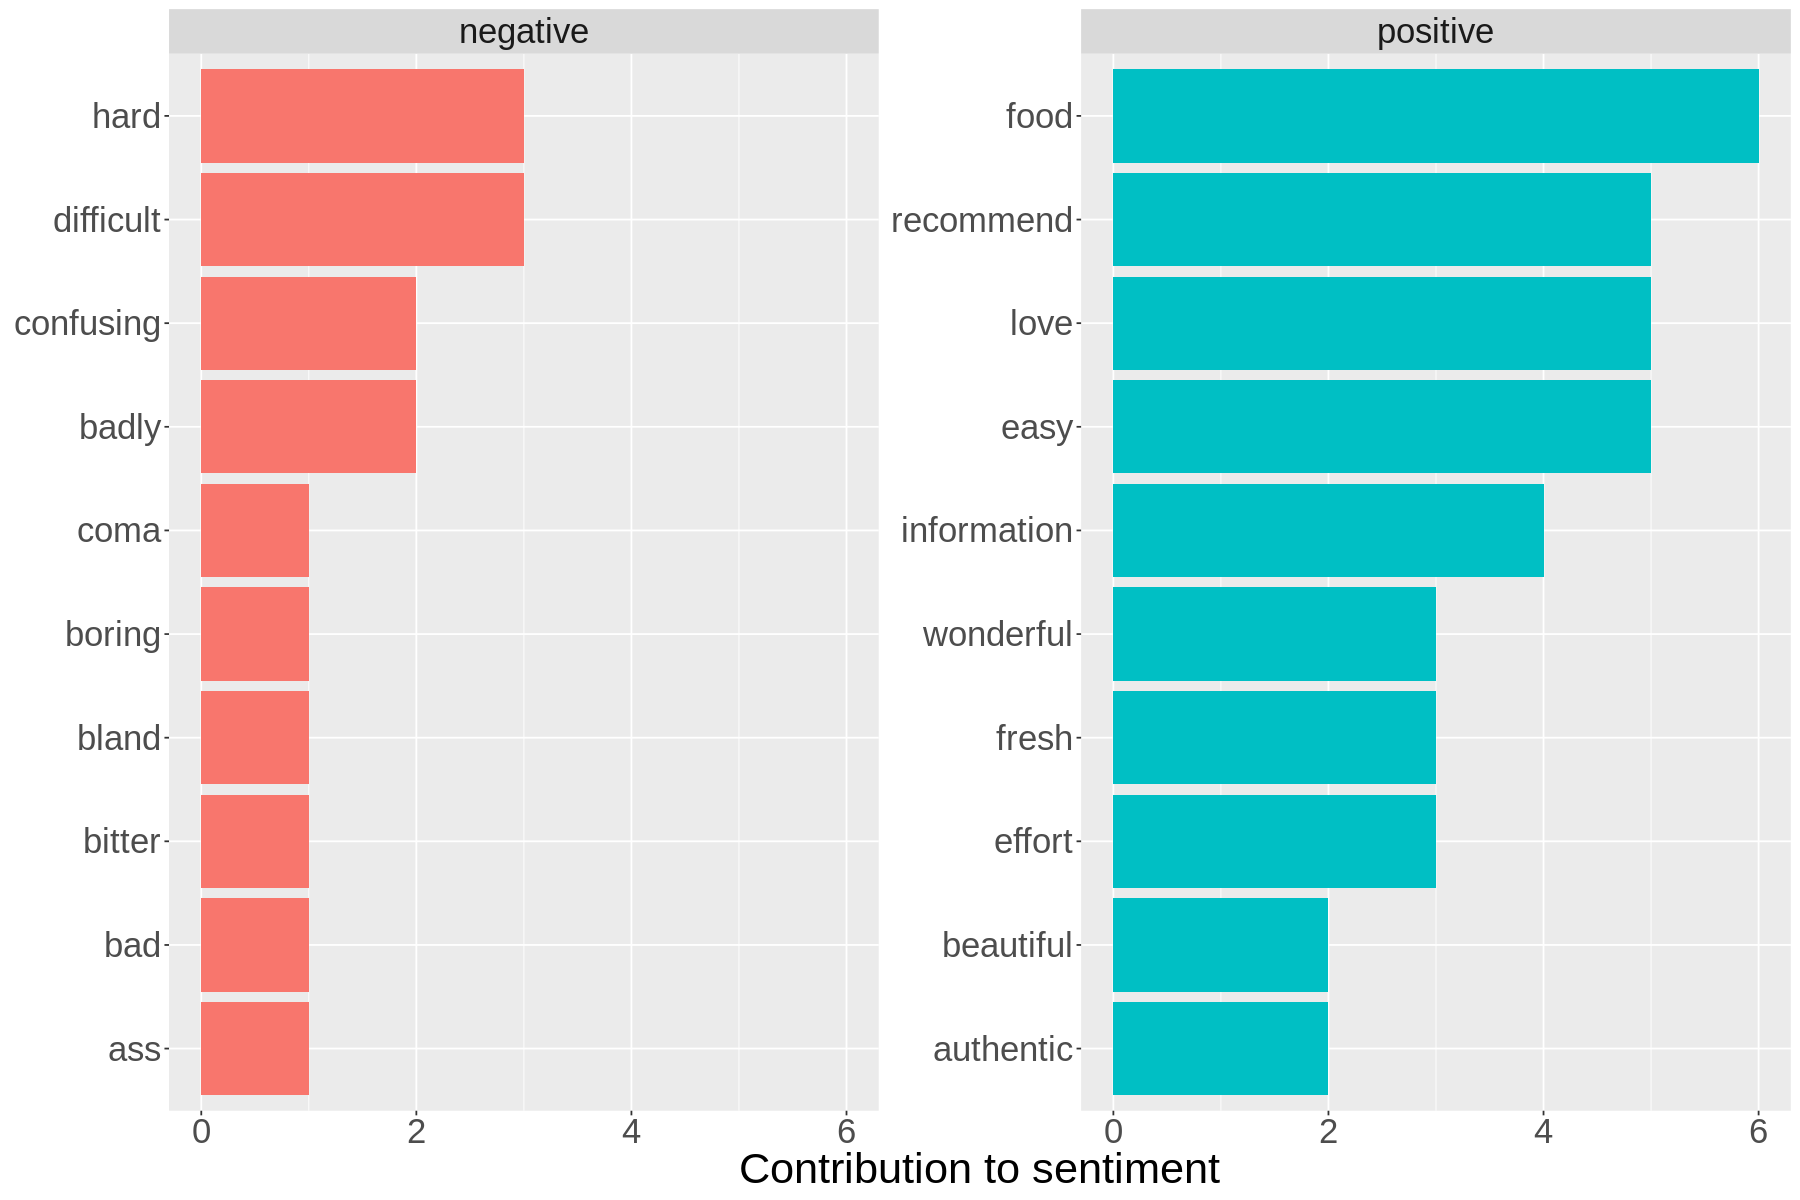

In [474]:
library(ggplot2)

options(repr.plot.width = 15, repr.plot.height = 10) # a wider, shorter figure
s2 %>%
  group_by(sentiment) %>%
  slice_max(n, n=10) %>% 
  ungroup() %>%
  mutate(word = reorder(word, n)) %>%
  ggplot(aes(n, word, fill = sentiment)) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~sentiment, scales = "free_y") +
  labs(x = "Contribution to sentiment",
       y = NULL) + 
  theme(text = element_text(size = 26)) 

In [475]:
myStopwords <- c(stop_words, "food")

In [476]:
# clean with the stopword
clean <- data %>% filter(!word %in% myStopwords$word)
#head(clean)

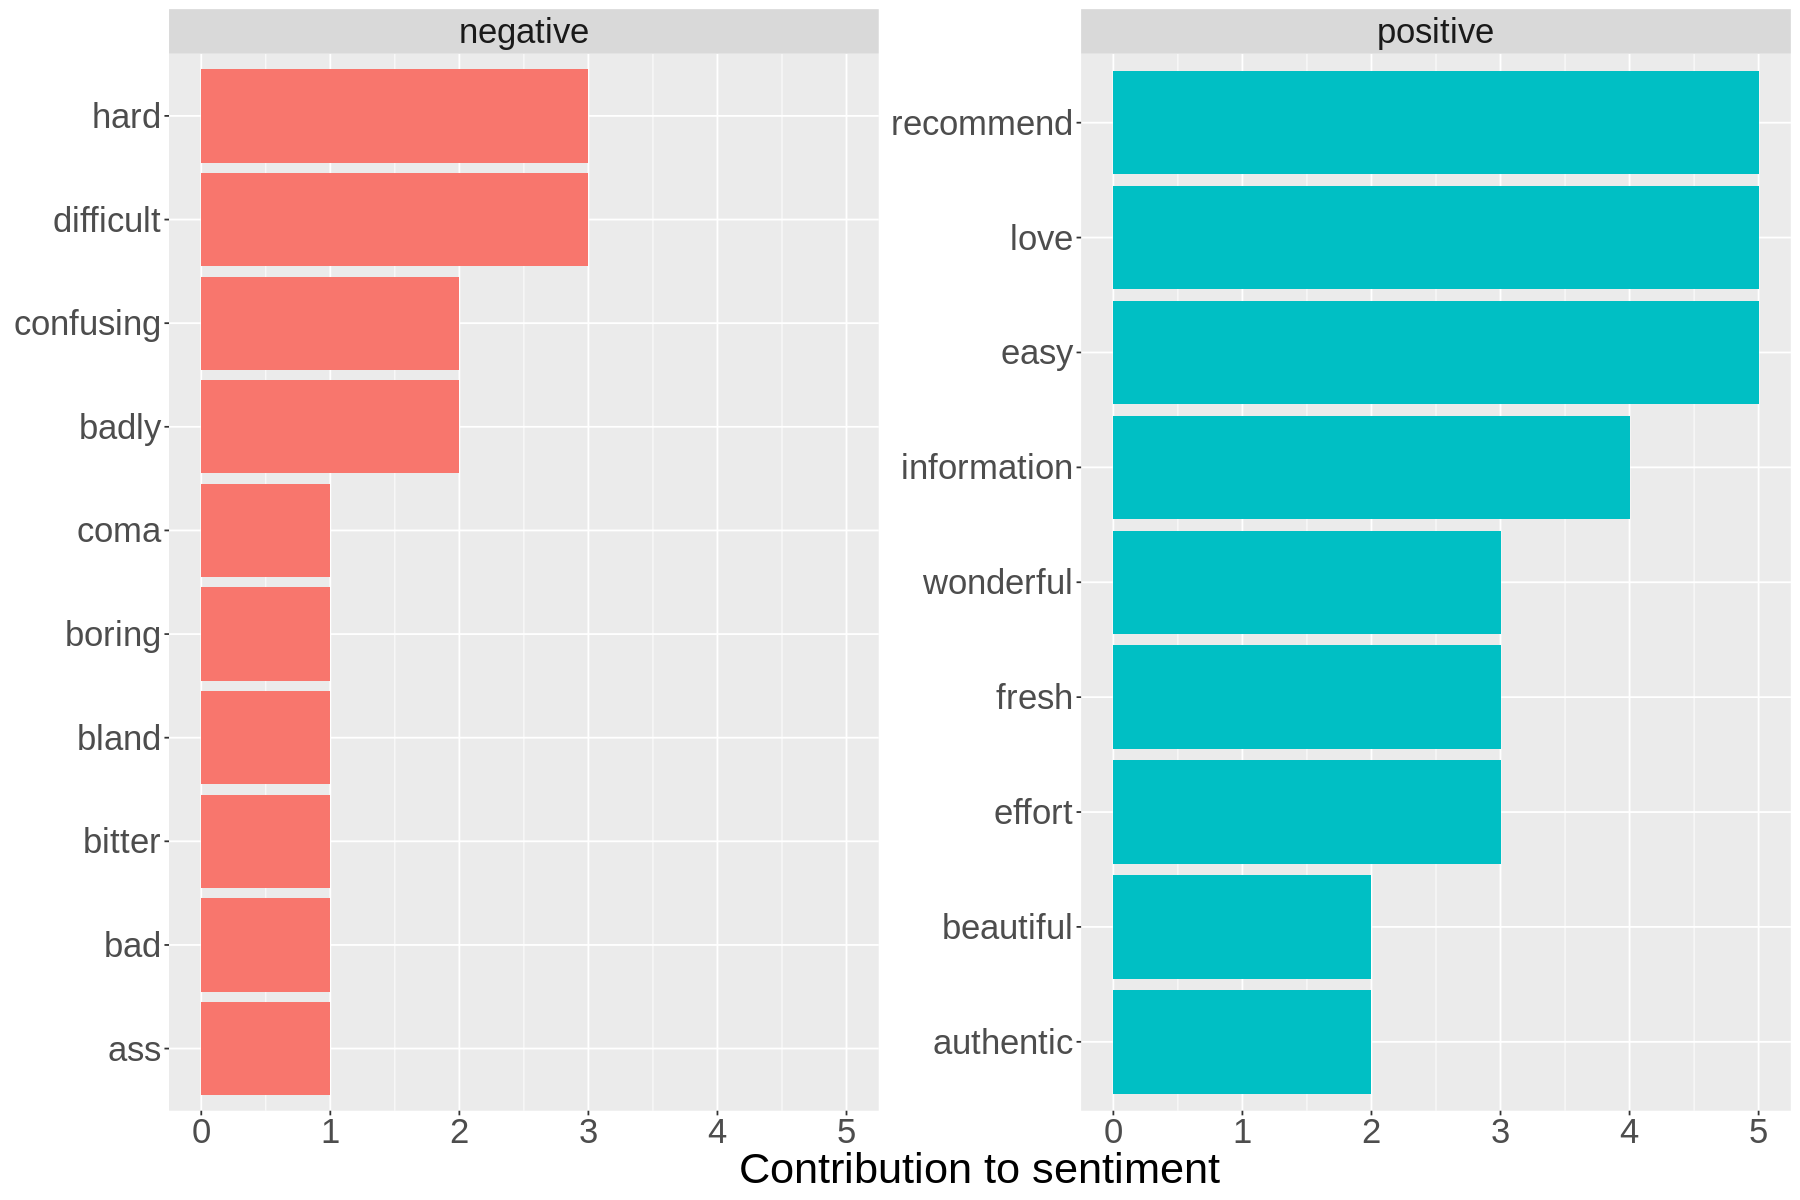

In [477]:
options(repr.plot.width = 15, repr.plot.height = 10) # a wider, shorter figure
s2 %>% filter(!word %in% 'food') %>%
  group_by(sentiment) %>%
  slice_max(n, n=10) %>% 
  ungroup() %>%
  mutate(word = reorder(word, n)) %>%
  ggplot(aes(n, word, fill = sentiment)) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~sentiment, scales = "free_y") +
  labs(x = "Contribution to sentiment",
       y = NULL) + 
  theme(text = element_text(size = 26)) 

J’ai agrégé mes 10 commentaires pour chaque livre ensemble. J’ai utilisé mon lexique de sentiment +/- développé dans la question 1 pour trouver le nombre de mots dans ces 3 lexiques. En premier lieu, le mot food arrive en tête de liste pour les mots positifs. Puisque mon analyse est faite sur des livres de cuisine, j’ai mis le mot food dans la liste de stopword. Je pourrais dire comme commentaire que la nourriture est mauvaise dans ce livre de recettes ce qui ne constituerais en rien un sentiment positif. Il est à noter qu’en raison que mon texte est petit, le nombre de sentiment est restreint. De fait, les mots négatifs comptabilisé à 1 tout comme les mots positifs comptabilisé à 2 sont vaste et ne sont pas tous représenté dans le graphique.

**4. Think of a way for quantifying the range of sentiments expressed in each document of a multi-document corpus in terms of at least one the three sentiment lexicons used in the example code.
Describe your approach conceptually, accompanied by a code snippet that implements this idea.**

In [478]:
sd1 <- clean %>% inner_join(afinn)
#sd2 <- sd1 %>% count(word, value, sort = TRUE) %>% ungroup()
head(sd1)

Joining, by = "word"


review_star,title,review,word,AFINN
<chr>,<chr>,<int>,<chr>,<dbl>
5.0 out of 5 stars,Italian,1,excellent,3
5.0 out of 5 stars,Italian,1,agree,1
5.0 out of 5 stars,Italian,1,complain,-2
5.0 out of 5 stars,Italian,1,ridiculous,-3
5.0 out of 5 stars,Italian,1,bad,-3
5.0 out of 5 stars,Italian,2,hard,-1


In [479]:
sd2 <- clean %>%
  inner_join(afinn) %>%
  group_by(title, review) %>%
  summarise(sentiment = sum(AFINN)) 
head(sd2)

Joining, by = "word"
`summarise()` has grouped output by 'title'. You can override using the
`.groups` argument.


title,review,sentiment
<chr>,<int>,<dbl>
China,21,-1
China,22,6
China,23,3
China,24,2
China,25,4
China,26,3


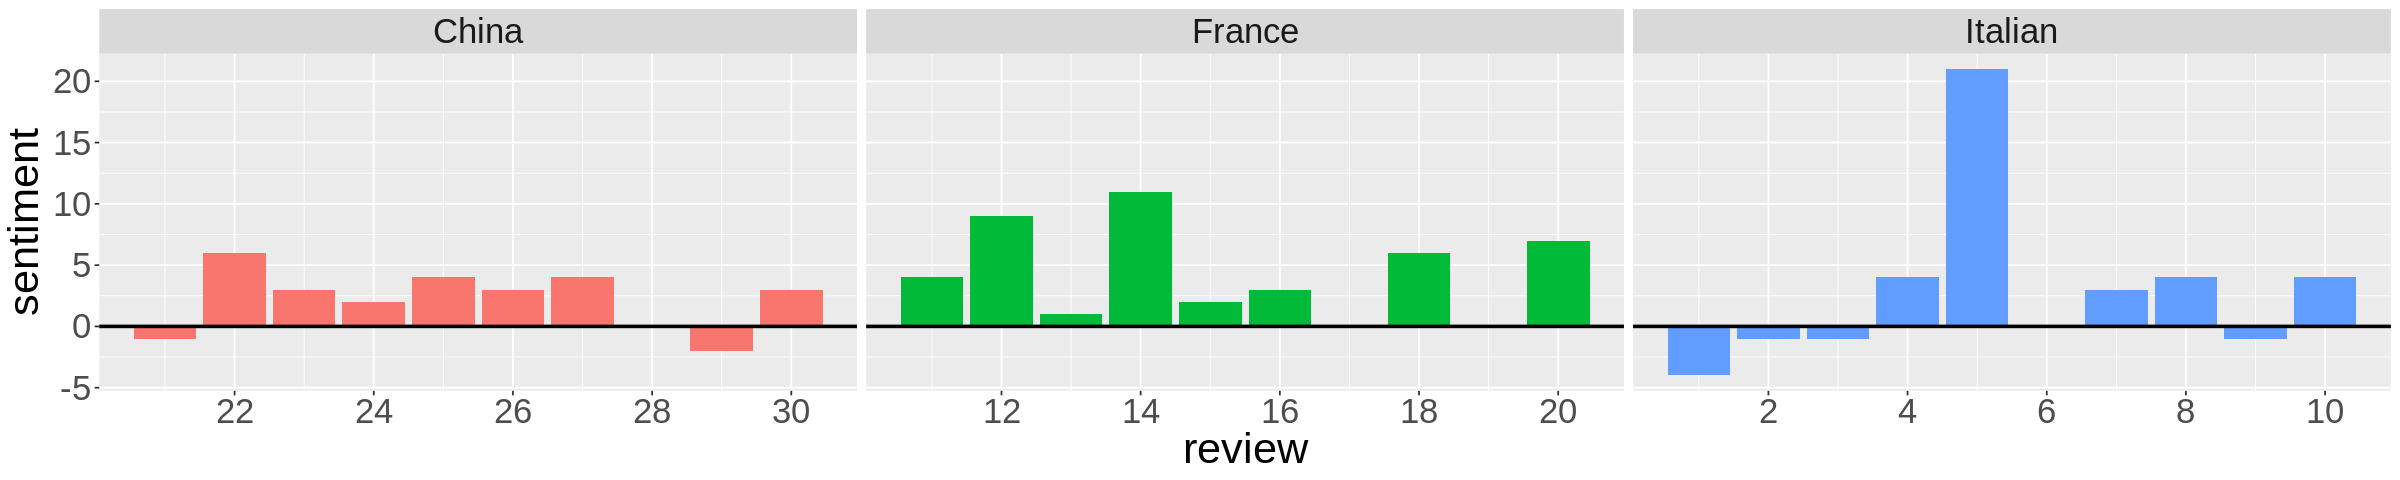

In [480]:
library(ggplot2)
library(repr)
library(scales)

options(repr.plot.width = 20, repr.plot.height = 4) # a wider, shorter figure

ggplot(sd2, aes(review, sentiment, fill = title)) + 
  geom_col(show.legend = FALSE) + 
  facet_wrap(~(title), ncol = 3, scales = "free_x") + 
  scale_x_continuous(breaks = pretty_breaks()) + 
  geom_hline(yintercept = 0, color = "black", size = 1) + 
  theme(text = element_text(size = 26)) 

J’ai utilisé le lexique afinn qui donne une valeur numérique pour chaque sentiment +/-. J’ai fait la somme de cette valeur pour chaque commentaire de chaque livre me donnant une idée globale de chaque commentaire. On peut donc voir que le cinquième commentaire du livre de cuisine italien semble très positif avec un pointage total de 21 versus le premier commentaire avec un pointage sommaire de -4. Dans l’ensemble, les 3 livres semblent être positif.

In [482]:
sd1 %>% filter(review==5)
sd2 %>% filter(review==5)
sd1 %>% filter(review==1)

review_star,title,review,word,AFINN
<chr>,<chr>,<int>,<chr>,<dbl>
5.0 out of 5 stars,Italian,5,amazing,4
5.0 out of 5 stars,Italian,5,shy,-1
5.0 out of 5 stars,Italian,5,positively,2
5.0 out of 5 stars,Italian,5,brilliant,4
5.0 out of 5 stars,Italian,5,easy,1
5.0 out of 5 stars,Italian,5,fresh,1
5.0 out of 5 stars,Italian,5,fresh,1
5.0 out of 5 stars,Italian,5,fresh,1
5.0 out of 5 stars,Italian,5,worth,2


title,review,sentiment
<chr>,<int>,<dbl>
Italian,5,21


review_star,title,review,word,AFINN
<chr>,<chr>,<int>,<chr>,<dbl>
5.0 out of 5 stars,Italian,1,excellent,3
5.0 out of 5 stars,Italian,1,agree,1
5.0 out of 5 stars,Italian,1,complain,-2
5.0 out of 5 stars,Italian,1,ridiculous,-3
5.0 out of 5 stars,Italian,1,bad,-3


**5. What percentage of the documents (whatever sub-elements of the text repository you choose to consider as documents in a sense) could be considered either neutral or mixed (in the sense that they are neither clearly positive nor clearly negative)?
Please include a code snippet that determines this**

In [483]:
first[6,]

content,review_star,title
<chr>,<chr>,<chr>
"Ma conjointe est tombée en amour avec ce livre. Très bonne achat, très bien expliqué le livre est en anglais mais avec une bonne base il y est facile de comprendre. Fortement recommandé",5.0 out of 5 stars,Italian


In [484]:
second[7, ]

content,review_star,title
<chr>,<chr>,<chr>
Broad coverage of french cuisine with lots of background and interesting tidbits of history as well. Thank you to Chef Ricardo for recommending it!,5.0 out of 5 stars,France


In [485]:
afinn %>% filter(word=='interesting')

word,AFINN
<chr>,<dbl>
interesting,2


In [486]:
stop_words %>% filter(word=='interesting')

word,lexicon
<chr>,<chr>
interesting,onix


In [487]:
sd1 %>% filter(review==17)

review_star,title,review,word,AFINN
<chr>,<chr>,<int>,<chr>,<dbl>


In [488]:
second[9, ]

content,review_star,title
<chr>,<chr>,<chr>
"Ouvrage complet, couvre la cuisine française de A à Z. Cadeau pour le chum cuisinier, il a adoré :)",5.0 out of 5 stars,France


In [489]:
third[8,]

content,review_star,title
<chr>,<chr>,<chr>
Good recipes. Only good thing would be a nutritional guide of how much calories and such.,4.0 out of 5 stars,China


In [490]:
sd1 %>% filter(review==28)

review_star,title,review,word,AFINN
<chr>,<chr>,<int>,<chr>,<dbl>


In [491]:
afinn %>% filter(word=='good')

word,AFINN
<chr>,<dbl>
good,3


In [492]:
stop_words %>% filter(word=='good')

word,lexicon
<chr>,<chr>
good,onix


In [493]:
p1 <- left_join(x = clean, y = afinn, by = 'word', all = TRUE)
head(p1)

review_star,title,review,word,AFINN
<chr>,<chr>,<int>,<chr>,<dbl>
5.0 out of 5 stars,Italian,1,recipes,NA
5.0 out of 5 stars,Italian,1,explained,NA
5.0 out of 5 stars,Italian,1,date,NA
5.0 out of 5 stars,Italian,1,excellent,3
5.0 out of 5 stars,Italian,1,agree,1
5.0 out of 5 stars,Italian,1,else's,NA


In [494]:
p2 <- p1 %>% mutate(AFINN = ifelse(is.na(AFINN), 0, AFINN))
tail(p2)

review_star,title,review,word,AFINN
<chr>,<chr>,<int>,<chr>,<dbl>
5.0 out of 5 stars,China,30,follow,0
5.0 out of 5 stars,China,30,pictures,0
5.0 out of 5 stars,China,30,recipe,0
5.0 out of 5 stars,China,30,highly,0
5.0 out of 5 stars,China,30,recommend,2
5.0 out of 5 stars,China,30,cookbook,0


In [495]:
p3 <- p2 %>% group_by(title, review) %>% summarise(sentiment = sum(AFINN))
head(p3)

`summarise()` has grouped output by 'title'. You can override using the
`.groups` argument.


title,review,sentiment
<chr>,<int>,<dbl>
China,21,-1
China,22,6
China,23,3
China,24,2
China,25,4
China,26,3


In [496]:
p4 <- p3 %>% mutate(neutral = ifelse(sentiment == 0, 1, 0)) %>% group_by(title) %>% summarise(neutral = sum(neutral))
head(p4)

title,neutral
<chr>,<dbl>
China,1
France,2
Italian,1


In [497]:
p5 <- left_join(x = combo1, y = p4, by = 'title', all = TRUE)
p6 <- p5 %>% group_by(title) %>% summarize("review neutral" = neutral/n) %>% ungroup()
p6

title,review neutral
<chr>,<dbl>
China,0.1
France,0.2
Italian,0.1


On peut voir dans mon graphique de la question 4 que certain commentaire semble neutre/mixte (somme des sentiments = 0). Deux commentaires sur les 30 sont en français. Il faudrait donc utiliser un lexique français pour ce type de commentaire. Deux autres commentaires sont en anglais. Certains mots semblent positifs comme interesting & good et se trouvent dans le lexique Afinn mais sont retiré dans les stopwords en raison que ces mots sont possibles de se retrouver avec une négation qui change le sens positif vers négatif du mot. Pour ces raisons, 10% de mes commentaires pour les livres de cuisine chinois et italien sont neutre comparativement à 20% pour la cuisine française.

**6. How would you visualize the results of such a sentiment quantification over a corpus?
Again, first discuss and then, if you wish, attach a code snippet.
If you do not write code, you can draw a conceptual visualization by hand to communicate your approach.**

In [498]:
sd3 <- clean %>%
  inner_join(afinn) %>%
  group_by(title, word) %>%
  summarise(sentiment = sum(AFINN)) 
tail(sd3)

Joining, by = "word"
`summarise()` has grouped output by 'title'. You can override using the
`.groups` argument.


title,word,sentiment
<chr>,<chr>,<dbl>
Italian,recommend,2
Italian,recommended,2
Italian,ridiculous,-3
Italian,shy,-1
Italian,wonderful,8
Italian,worth,4


In [499]:
sd3 <- sd3[order(sd3$title, sd3$sentiment, decreasing = TRUE),] %>% 
  mutate(n = ifelse(sentiment < 0, 'negative', 'positif'))
head(sd3)

title,word,sentiment,n
<chr>,<chr>,<dbl>,<chr>
Italian,wonderful,8,positif
Italian,excellent,6,positif
Italian,amazing,4,positif
Italian,brilliant,4,positif
Italian,worth,4,positif
Italian,excellence,3,positif


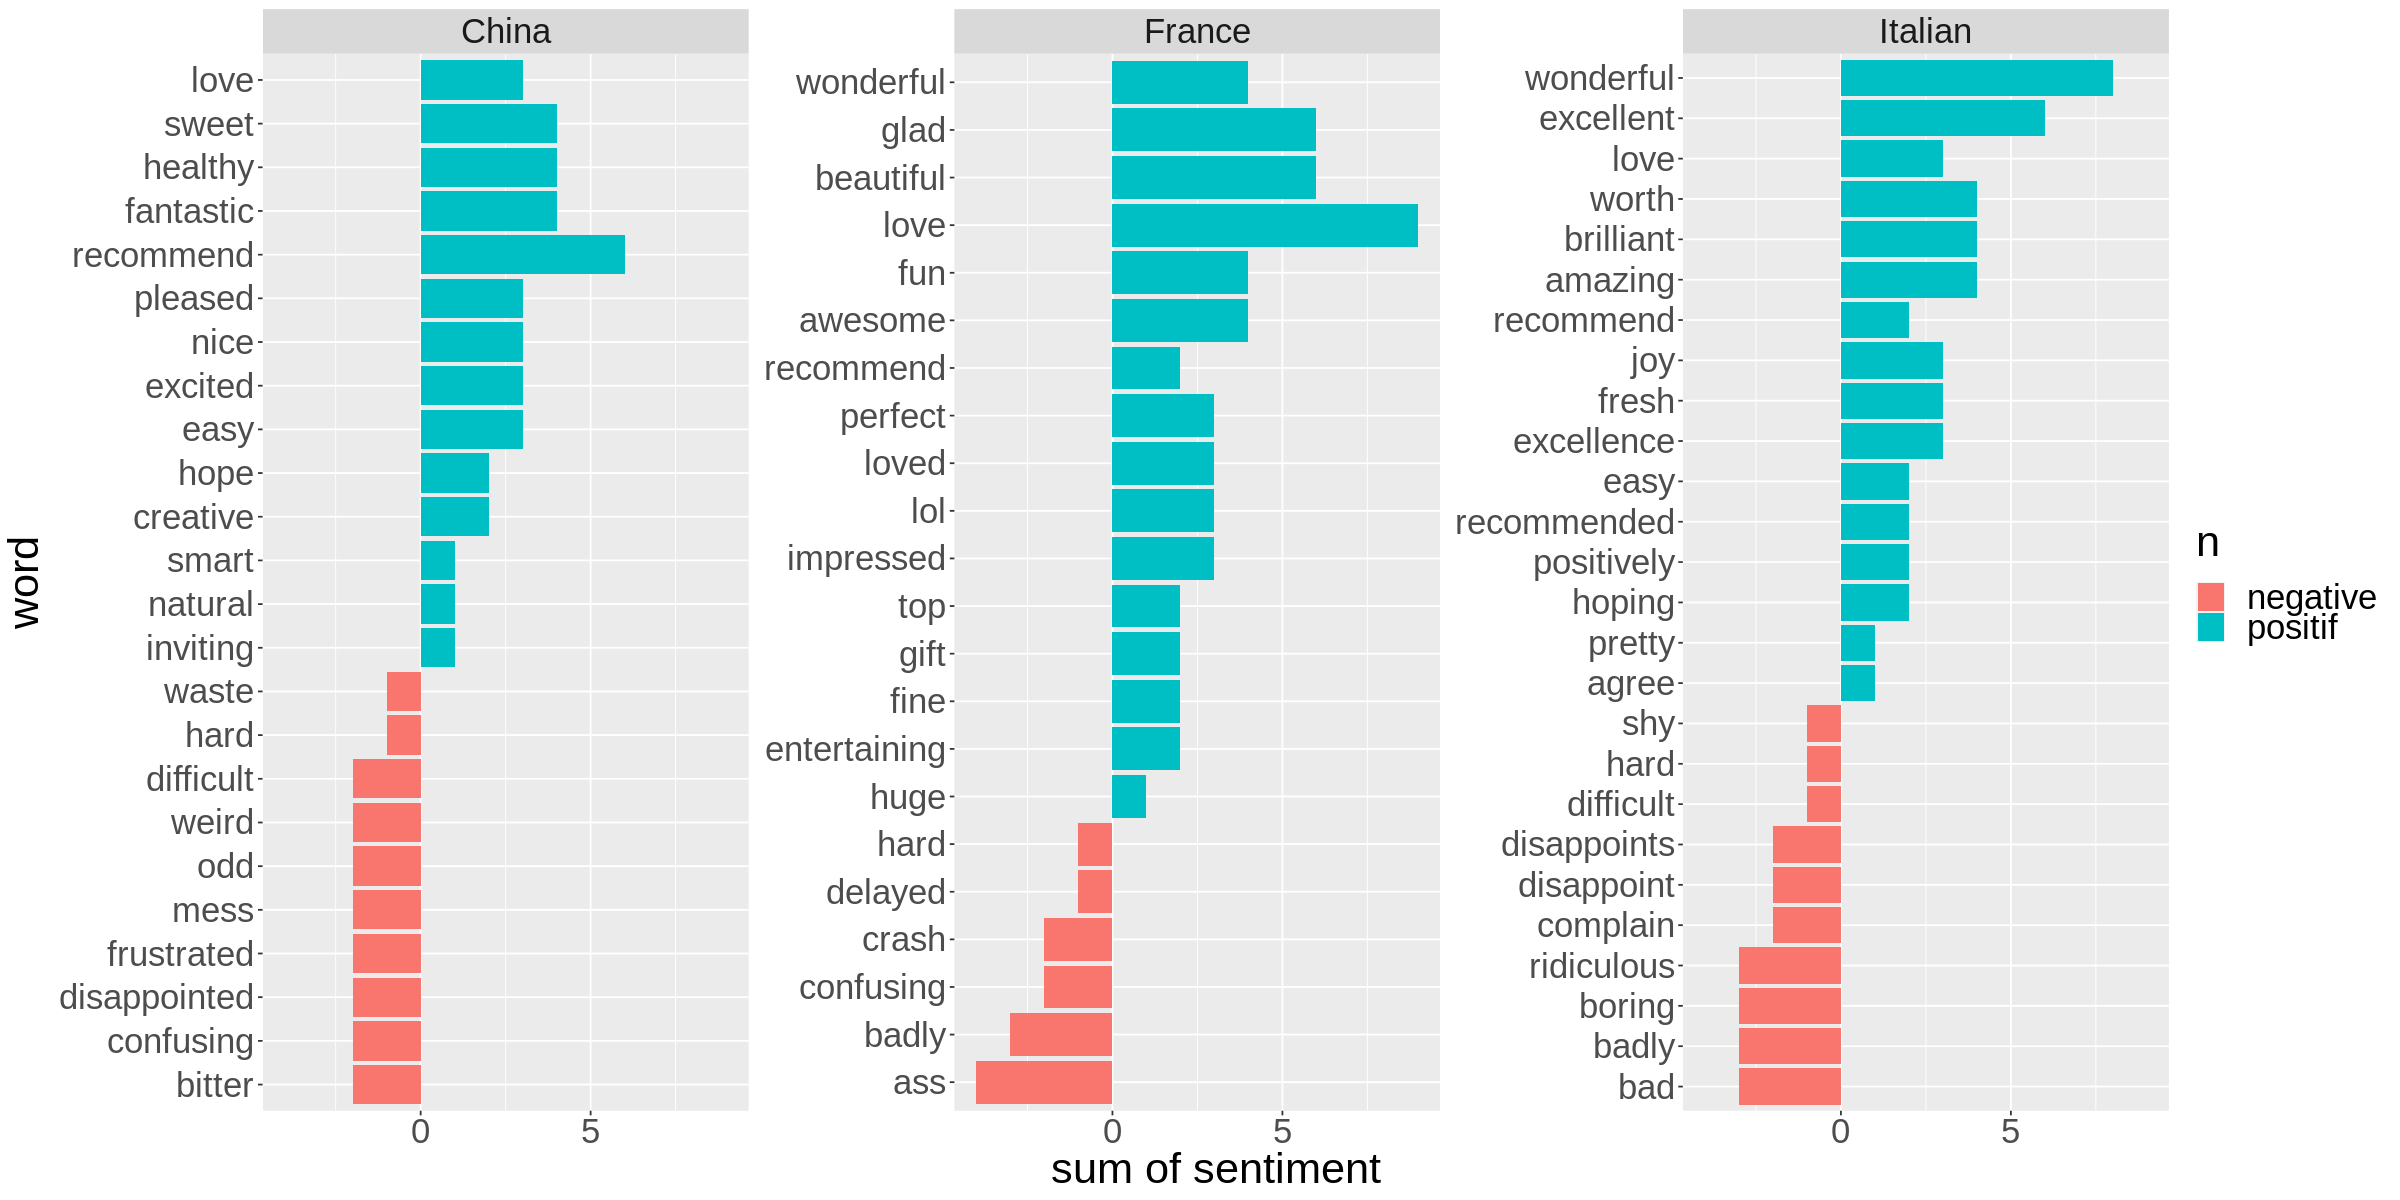

In [511]:
options(repr.plot.width = 20, repr.plot.height = 10) # a wider, shorter figure

sd3 %>% #filter(title=='Italian') %>% 
#mutate(word = reorder(word, sentiment)) %>%
 #mutate(word = fct_reorder(word,rank)) %>%

 ggplot(aes(sentiment, reorder(word, sentiment ,decreasing=F), fill = n))+
 xlab('sum of sentiment')+
 ylab('word') +
 geom_col() +
 #coord_flip() +
 theme(text = element_text(size = 26)) +
 facet_wrap(~title, ncol = 3, scales = "free_y")

In [501]:
install.packages("reshape2") # for acast, this a new one for us
library(reshape2)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [502]:
install.packages("wordcloud") # we already used this in Session 2
library(wordcloud)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [503]:
sd4 <- clean %>%
  inner_join(afinn) %>%
  group_by(word) %>%
  summarise(sentiment = sum(AFINN)) %>% 
  mutate(n = ifelse(sentiment < 0, 'negative', 'positif'))
tail(sd4)

Joining, by = "word"


word,sentiment,n
<chr>,<dbl>,<chr>
sweet,4,positif
top,2,positif
waste,-1,negative
weird,-2,negative
wonderful,12,positif
worth,4,positif


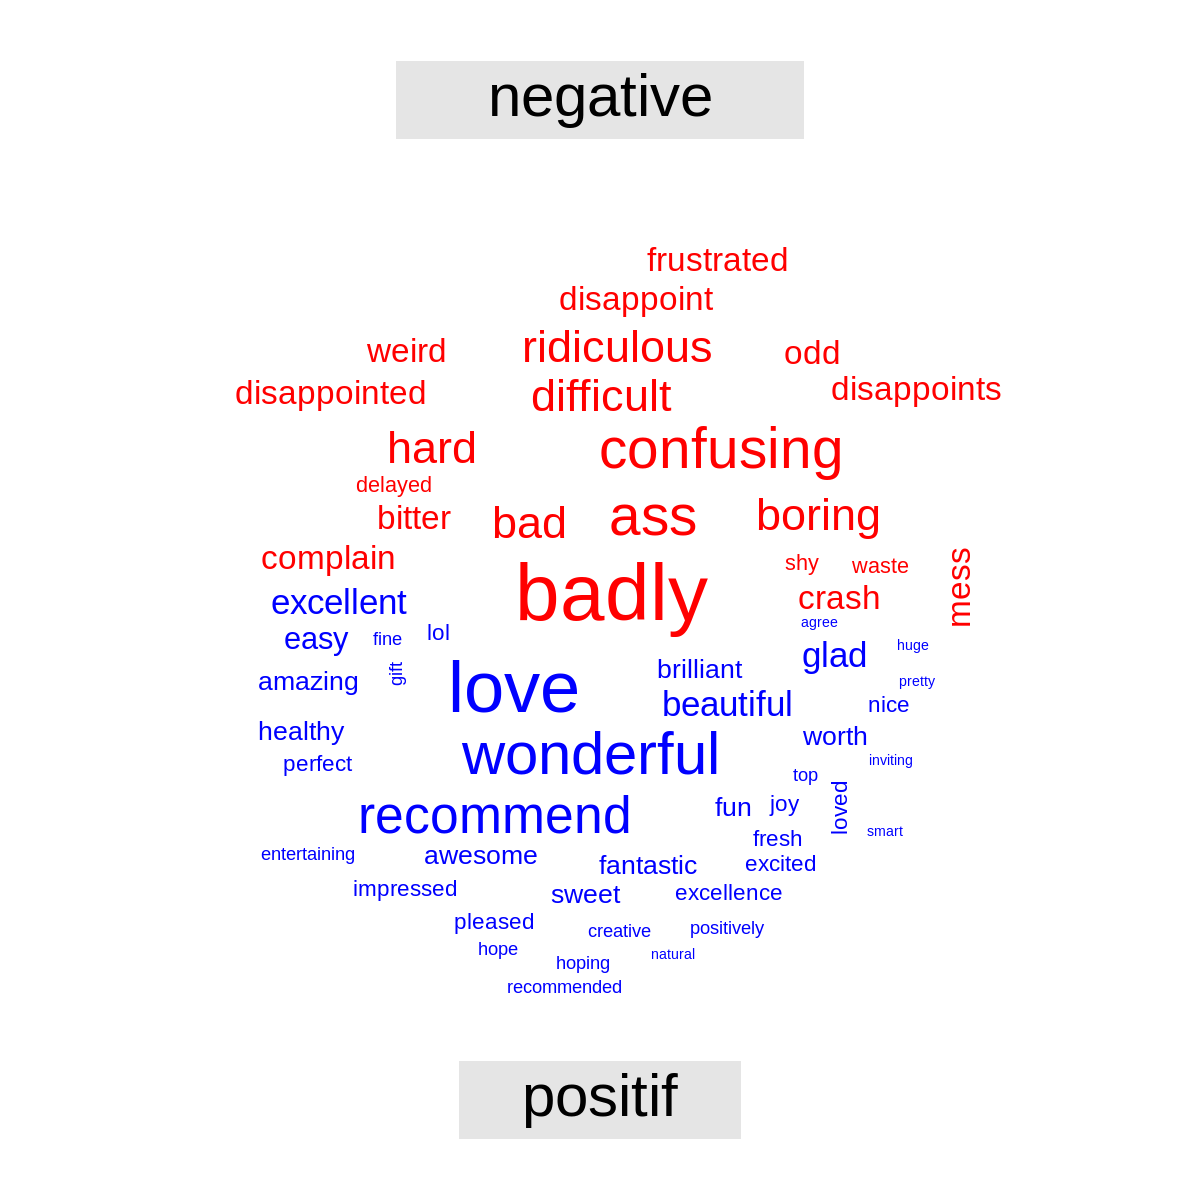

In [504]:
options(repr.plot.width = 10, repr.plot.height = 10) # a square figure  
sd4 %>% acast(word ~ n, value.var = "sentiment", fill = 0) %>% comparison.cloud(colors = c("red", "blue"), max.words = 100)

Dans la question 4, j’ai produit une visualisation par commentaire de chaque livre de cuisine pour la somme des sentiments du lexique afinn. Ainsi nous pouvons voir par commentaire s’il est généralement plus positif, neutre/mixte ou négatif. Pour voir chaque sentiment associé pour chaque livre, j’ai produit un graphique qui somme les valeurs numériques de chaque livre pour les sentiments trouvés dans le lexique afinn (je n’ai juste pas trouvé le moyen de faire un ordre sur les sentiments dans le graphique). Nous pouvons donc voir que pour chaque livre, les mots positifs sont majoritaires et de quels sentiments ils en sont constitués avec leur pointage. Pour le corpus, j’ai fait un wordcloud comme dans le cours qui montre les mot négatif / positif. La grosseur du mot indique la somme de la valeur numérique du lexique afinn.

**7. Do you expect a sentiment quantification of product reviews to somehow (cor)relate to the associated star/numerical ratings?
You may either try this out in code and interpret the results or speculate conceptually on what you would expect to find.**

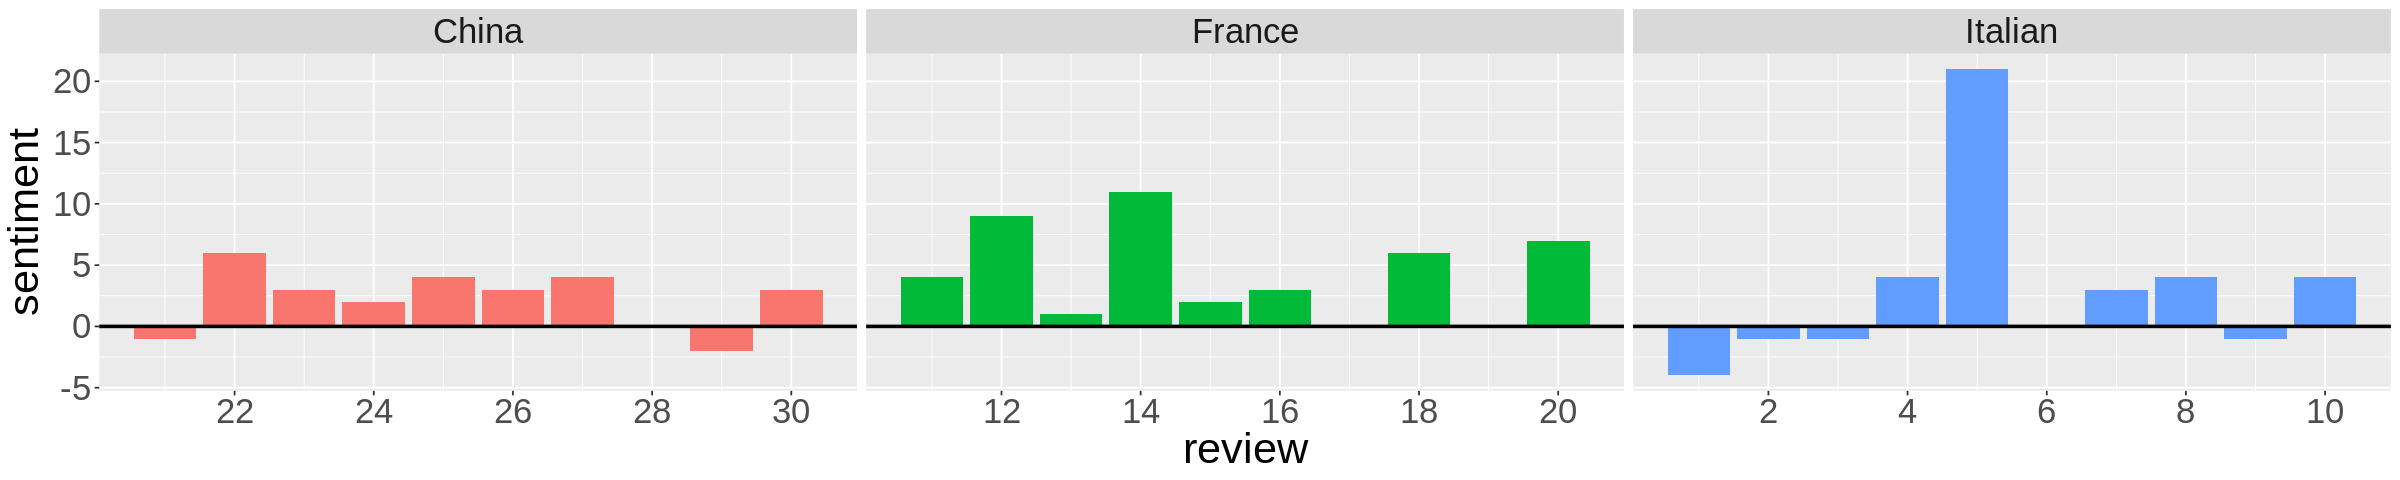

In [505]:
options(repr.plot.width = 20, repr.plot.height = 4) # a wider, shorter figure

ggplot(sd2, aes(review, sentiment, fill = title)) + 
  geom_col(show.legend = FALSE) + 
  facet_wrap(~(title), ncol = 3, scales = "free_x") + 
  scale_x_continuous(breaks = pretty_breaks()) + 
  geom_hline(yintercept = 0, color = "black", size = 1) + 
  theme(text = element_text(size = 26)) 

In [506]:
first

content,review_star,title
<chr>,<chr>,<chr>
"The recipes are very well explained and although I have only done a few to date they were excellent. I agree with someone else's comments on the basic red sauce - best ever and only 3 ingredients - so simple and prefect. I made it for two young grandchildren and they both said it was the best sauce ever. For those who complain about no pictures I say it's a cookbook, not a photo album. Ridiculous reason to give a cookbook a bad rating. I am buying another copy for my daughter-in-law.",5.0 out of 5 stars,Italian
"Even with the internet and the rise of cooking blogs and recipe sites, there are certain cookbooks I think one should own, preferably in hard cover. Marcella Hazan’s Classic Italian is one of those books.In my humble opinion of course.",5.0 out of 5 stars,Italian
I was hoping for more from this book. The few recipes I made were uneventful. The simple onion/butter tomato sauce was extremely bland and boring. If you don't know how to cook at all then this book will help you develop some basics. It doesn't do a good job at teaching you how to develop flavors so that you'll actually want to eat the meal.,3.0 out of 5 stars,Italian
"So far it's wonderful. Not only do you get an incredibly vast library of wonderfully authentic recipes, but also some history as well as instructions on technique and kitchen hardware essentials. She also covers what every good Italian pantry should have on hand. If you want Italian cuisine this is the only book you'll ever need.",5.0 out of 5 stars,Italian
"This is an amazing book for those who are not shy about cooking from scratch. The recipes are positively brilliant and easy to follow. That said, it is not for the faint of heart...there is a lot of prep for fresh vegetables, fresh meats and all other manner of fresh ingredients. But the effort is more than worth the time and energy required. My husband & I entered a ""food coma"" after stuffing ourselves with the pizza recipes in this book...it was the first recipe I tried after my sister recommended the book to me...her family may never ever again go to a restaurant for dinner now that my sister has discovered this book. I cannot say enough wonderful things about the recipes found in this cook book. Bravo and bon appetite !",5.0 out of 5 stars,Italian
"Ma conjointe est tombée en amour avec ce livre. Très bonne achat, très bien expliqué le livre est en anglais mais avec une bonne base il y est facile de comprendre. Fortement recommandé",5.0 out of 5 stars,Italian
"The book itself is excellent, an incredible resource. However it was delivered with the corners pretty badly damaged. Seems standard for Amazon to deliver books this way, not wrapping them properly and seriously damaging them. Disappointing.Honestly I would recommend finding a local bookstore that has this in stock instead.",2.0 out of 5 stars,Italian
"I haven't made any recipes yet but this book doesn't disappoint. I love that like the joy of cooking, there is a lot of instruction for how to prep and prepare the foods, not just a recipe. I'm 126 pages in and have already learned quite a bit .",4.0 out of 5 stars,Italian
"The best of the best Italian cookbook I've ever owned. It's the kind of the book that the recipes are really authentic and the outcome is really delicious, which, according to my experience, is extremely rare nowadays. I've had it for more than 4 years and have tried many recipes on it. As far as I can remember, only two recipes disappoints me (and I'm a really difficult person when it comes to food). I also bought many other Italian cookbooks, with many mouth-watering pictures but most of the time, the outcome following those books are mediocre and do not worth the effort.",5.0 out of 5 stars,Italian


In [507]:
sd1 %>% filter(review==1)

review_star,title,review,word,AFINN
<chr>,<chr>,<int>,<chr>,<dbl>
5.0 out of 5 stars,Italian,1,excellent,3
5.0 out of 5 stars,Italian,1,agree,1
5.0 out of 5 stars,Italian,1,complain,-2
5.0 out of 5 stars,Italian,1,ridiculous,-3
5.0 out of 5 stars,Italian,1,bad,-3


Intuitivement, j’aurais pensé que la somme des valeurs numériques du lexique afinn (graph Q4) me donnerait une bonne idée de ce que pourrait être le score du commentaire. Il n’en est rien! Le résultat du graphique pour le premier commentaire du livre Italien et le plus négatif alors qu’il a reçu un score de 5/5. Le 7 ième commentaire du même livre est plutôt positif alors qu’il a reçu une note de 2/5. 

Chapitre 4. Relationships between words: n-grams and correlations

En utilisant le bigram, nous pourrions améliorer notre analyse de sentiment. Pour corriger le sens d’une émotion (ex : not happy).


Text-rating review discrepancy (TRRD): an integrative review and implication for research
https://fbj.springeropen.com/articles/10.1186/s43093-022-00114-y

Dans le lien ci-dessus, ils ont examiné des articles de de recherche pour évaluer la relation entre les commentaires et les scores de notation associée. Ceci s’est avéré une corrélation faible à moyenne. Par conséquent, la construction de modèle basé uniquement sur les sentiments des textes ou des scores numériques doit être utilisée avec prudence. Suggère de regarder au-delà des évaluations numériques dans les sentiments du texte puisqu’ils peuvent exprimer plus d’informations que les évaluations quantitatives ne peuvent pas capturer.

Selon le livre ci-dessous :
Speech and Language Processing – Chapter 20.5 Supervised Learning of Word Sentiment

Les mots positifs ont une plus grande probabilité d’avoir un score de 5 étoiles alors que les mots négatifs d’avoir une étoile. Au lieu d’utiliser une polarité (négatif / positif), la supervision permet d’attribuer à un mot une représentation plus complexe, soit sa répartition sur un score. Ex : Probabilité (mot = décevant | 1 étoile). Les résultats peuvent être ensuite ‘normalized likelihood’ afin d’obtenir une visualisation (diagramme de Potts) qui représente la distribution d’un sentiment à travers sa catégorie de score. Ce diagramme peut être utilisé comme typologie lexical et modélise la composition du sentiment.

Pour savoir le mot le plus associé à 1 étoile vs. 5 étoiles : Log Odds ration informatice dirichlet prior
Cette différence (mots avec étoile 1 vs. 5) ne doit pas être seulement relié au sentiment. Nous devons calculer la différence en utilisant le log odds ratio informative. Cela est utile pour trouver des mots qui sont statistiquement surreprésentés dans une catégorie particulière dans des textes. Ainsi nous pouvons retrouver les mots et particularité de sentiments qui se retrouve dans les avis à une étoile vs. 5 étoiles par exemple.


**8. Search on Google Scholar for recent contributions to the state of the art on sentiment analysis within the field of NLP.
Please provide the DOI for three that you find interesting and briefly describe what the authors propose.**

**A survey on sentiment analysis methods, applications, and challenges**

https://link.springer.com/article/10.1007/s10462-022-10144-1

Aperçu complet de la méthode pour accomplir une analyse sur les sentiments ainsi que de leurs applications. Évaluation et compare les approches utilisées pour une compréhension des avantages et inconvénients. Finalement, les défis que cela apporte afin de définir les orientations futures.
-	Le niveau de l’analyse : document, phrase.
-	Collection des données et sélection des caractéristiques
-	Méthodologie : Lexique, Corpus, Dictionnaire.
-	Machine Learning: Naive Bayes, SVM, Logistic regression, decision tree, maximum entropy, KNN, smi-supervised learning, hybrid approach, NN, ABSA, transfer learning, MSA.
-	Évaluation des paramètres de performance :  Accuracy, F1 score, precision. Deep Learning : Accuracy, recall.
-	Application : examen des produits, marketing, santé, gestion de la réputation, marché boursier, voix des clients, surveillance des médias sociaux.
-	Défis : sentiment structuré / semi-structuré / non structuré. Sarcasme, style de l’écriture, les fautes d’orthographes, le coût de calcul, les données disponible, l’adaptation du langage 

**Transformer-Based Graph Convolutional Network for sentiment Analysis**

https://doi.org/10.3390/app12031316

Proposition d’un nouveau ST-GCN. « Modélise le corpus de sentiments sous la forme d’un graph hétérogène et à apprendre les incorporations de documents et de mots à l’aide du réseau de transformateurs de graphes de texte propos.  Offre un mécanisme simple pour fusionner les informations de position des nœuds pour les ensembles de données graphiques à l’aide de vecteurs propres Laplacien. Le modèle surpasse les méthodes de classification des sentiments. » On vient de me perdre… mais je trouvais intéressant d’avoir un article sur les transformer étant donné que je pense que cela est souvent utilisé.

**The power of ensemble learning in sentiment analysis**

https://doi.org/10.1016/j.eswa.2021.115819

Ensembles de modèles d’apprentissages dont les prédictions individuelles sont combinées afin de compenser les faiblesses des autres. Cette méthode semble être limité pour l’instant dans la classification des sentiments. Plusieurs techniques d’ensembles hétérogènes sont appliquées et évaluées. Amélioration médiane des performances allant jusqu’à 5.53% par rapport au meilleur modèle individuel est observé.


**9. Now, search online for existing applications of NLP sentiment analysis.
Please provide the URL and a brief description of each, indicating who applies it (company, university, government) and to what exactly (the inputs, the output, and the context in which it is applied).**

https://www.repustate.com/blog/sentiment-analysis-real-world-examples/

**Banque (Sud Afrique) :**
Inquiétude par rapport à sa perception sur le marché en raison d’une concurrence féroce, la banque voulait s’assurer de garder ses clients. Extraction de textes lors de campagne sur les médias sociaux menée avec des hashtags. Utilisation de la reconnaissance d’entité nommée afin de déchiffrer le sens dans l’intention du commentaire présenté dans une visualisation pour fin de compréhension. Résultat :  la plupart des plaintes proviennent du manque de service durant le déjeuner. La banque a mis en place un processus pour résorber cette problématique. Réduction de l’attrition et augmentation de nouveaux clients par la suite.


**Gouvernement (Asie-Pacifique) :**
Souhaite accroître l’efficacité de ses services publics et être proactif dans le service auprès de ses citoyens. Désire connaître les principaux problèmes (embouteillage, passeport, etc.) afin de les résoudre. Utilisation des données provenant du gouvernement. Analyse des sentiments basée sur l’aspect pour ensuite les segmenter davantage en d’autres sous-ensembles en fonction du sexe, de l’heure, de la nature du commentaire, etc. La solution des informations pour le regroupement sémantique a permis de pouvoir prendre de bonnes décisions au sein du gouvernement pour être plus agile et efficace.


**Hedge Fund (Asie-Pacifique) :**
Désire analyser les données du marché en temps réel. Besoin de réflexes rapides pour effectuer des transactions très rapidement. Cependant la plupart des informations de presse étaient en mandarin ce qui causait un frein en raison de la langue. Extraction d’entités multilingues sur des articles de presses diffusés tout au long de la journée afin de créer un tableau de bord en temps réel pour couvrir le sentiment du marché et les cours des actions. Ceci a permis à l’entreprise de se préparer à une baisse ou à une hausse du marché à tout moment.
